In [1]:
import xarray as xr
import numpy as np
from Algorithms.Parse_UALF import *
import time as T
import seaborn as sns
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
sns.set()

In [3]:
basis = xr.open_dataset("source_disk/basis_remapped4.nc").rename({"helicopter_triggered_index":"lightning count winter"})

In [4]:
basis["lightning count winter"] = basis["lightning count winter"]*0
basis["lightning count summer"] = xr.zeros_like(basis["lightning count winter"]).rename({"lightning count summer"})

In [5]:
lat,lon = basis["latitude"],basis["longitude"]

In [6]:
basis["lightning count winter"]

<xarray.DataArray 'lightning count winter' (y: 268, x: 238)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    longitude  (y, x) float64 ...
    latitude   (y, x) float64 ...
Dimensions without coordinates: y, x

In [7]:
print(lat[0][0].values,lon[0][0].values)
print(lat[-1][0].values,lon[-1][0].values)
print(lat[-1][-1].values,lon[-1][-1].values)
print(lat[0][-1].values,lon[0][-1].values)

coord_filter = [49.76,72.77,-18.12,54.24]

50.3199999521046 0.278000680721756
72.7627114670165 -18.1233660061476
71.5764021592218 54.2417955372544
49.7658066162535 33.0273690650967


In [8]:
["Version","Year","Month","Day of month","Hour","Minutes","Seconds","Nanoseconds","Latitude","Longitude","Peak Current"][8:10]

['Latitude', 'Longitude']

In [8]:
def filter_UALF(inname,outname,coord_filter):
    """
    filter is a list of minlat,maxlat,minlon,maxlon, 
    anything outside this box is filtered out of output
    """
    minlat,maxlat,minlon,maxlon = coord_filter
    with open(inname,"r") as infile:
        with open(outname,"w") as outfile:
    
            for line in infile:
                lat,lon = line.split()[8:10]
                lat = float(lat);lon=float(lon)
                flag = 1
                if not (minlat < lat and maxlat > lat):
                    flag = 0

                if not (minlon < lon and maxlon > lon):
                    flag = 0

                if flag:
                    outfile.write(line)

            return 
        

In [111]:
for year in range(2008,2020):
    print(year)
    datas_buffer = filter_UALF("source_disk/lightning/lightningdata%i.txt"%year,"source_disk/lightning/lightningdata%i_filtered.txt"%year,coord_filter)

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [ ]:
terskel = 10 #km
total = T.time()
R = 6371 #km 



def indexing():
    global place
    # If the closest cell is more than 1 degree away, return 0
    distance = np.sqrt( (place[0] - lat)**2 + (place[1]-lon)**2)
    if np.min(distance) > terskel:
        return 0
    ind = np.unravel_index(np.argmin(distance,axis=None).values,lat.shape)
    return ind


k_list=[]

for year in range(2008,2020):
    k = 0
    print("Parsing UALF for year: "+str(year))
    datas_buffer = get_Lyn_Data("source_disk/lightning/lightningdata%i.txt"%year)
    print("Done parsing UALF for year: "+str(year))
    start = T.time()
    for data in datas_buffer:
        time,place = data
        
        ind = indexing()
        # If zero was returned, go to next entry
        if not ind:
            continue
        
        # Winter season October (10) to april (4)
        if time.month < 5 or time.month > 9:
            basis["lightning count winter"].isel(y=ind[0],x=ind[1]).values += 1
            
        # Summer season May (5) to September (9)
        else:
            basis["lightning count summer"].isel(y=ind[0],x=ind[1]).values += 1
        k+=1 
                
        if k%100000 ==0:
            end = T.time()
            elapsed = end - start
            start = T.time()
            print("Counted 100 k lightning in ",elapsed)
            
    k_list.append(k)   
    print("Year %i had %i lightning counted"%(year,k))
    
print("Total time elapsed:",T.time()-total,"seconds")     

Parsing UALF for year: 2008
Done parsing UALF for year: 2008
Counted 100 k lightning in  310.09998059272766
Counted 100 k lightning in  312.3452899456024
Counted 100 k lightning in  345.0875005722046
Counted 100 k lightning in  289.72387051582336
Counted 100 k lightning in  271.0792944431305
Counted 100 k lightning in  270.5627555847168
Counted 100 k lightning in  271.94851064682007
Counted 100 k lightning in  266.0711727142334
Counted 100 k lightning in  264.5783553123474
Counted 100 k lightning in  265.1457920074463
Counted 100 k lightning in  264.5300328731537
Counted 100 k lightning in  264.15539503097534
Year 2008 had 1294699 lightning counted
Parsing UALF for year: 2009
0	2009	7	18	12	32	17	677487272	56.3988	16.4631	-4	0	2	1	140.20	9.90	0.40	0.00	1.4	30.2	-0.0	0	1	1



In [ ]:
standard_parallels = (63.3, 63.3)
central_longitude = 15.0
central_latitude = 63.3
proj = ccrs.LambertConformal(central_longitude=central_longitude,central_latitude=central_latitude,standard_parallels=standard_parallels)

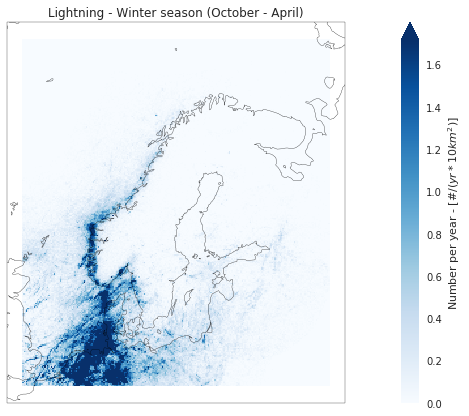

In [252]:
plt.figure(figsize=(20,7))
ax = plt.axes(projection=proj)
(basis["lightning count winter"].isel(x=range(1,237),y=range(1,267))/(10*7)).plot(ax=ax,cmap="Blues",robust=1,
                                                                        x='longitude', y='latitude',
                                                                        transform=ccrs.PlateCarree(),cbar_kwargs=
                                                                        {
                                                                        "label" : r"Number per year - $[\#/(yr*10km^{2})]$"    
                                                                        }
                                                                        )
ax.coastlines("50m")
ax.set_title("Lightning - Winter season (October - April)")
plt.show()

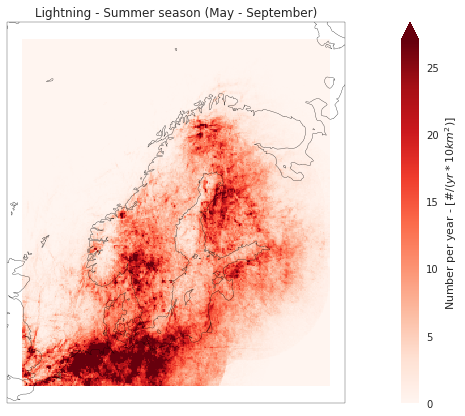

In [253]:
plt.figure(figsize=(20,7))
ax = plt.axes(projection=proj)
(basis["lightning count summer"].isel(x=range(1,237),y=range(1,267))/(10*5)).plot(ax=ax,cmap="Reds",robust=1,x='longitude', y='latitude',
                                                                 transform=ccrs.PlateCarree(),cbar_kwargs=
                                                                 {
                                                                 "label" : r"Number per year - $[\#/(yr*10km^{2})]$"    
                                                                 }
                                                                )
ax.coastlines("50m")
ax.set_title("Lightning - Summer season (May - September)")
plt.show()

In [142]:
basis = xr.open_dataset("source_disk/results/preliminary_lightning.nc")

In [57]:
print(k_list)

[1193313, 1579933, 1988750, 2365967, 1124785, 1472031, 2726636, 949134, 1361568, 1450889, 3542909]


In [121]:
basis

<xarray.Dataset>
Dimensions:                 (x: 238, y: 268)
Coordinates:
    longitude               (y, x) float64 ...
    latitude                (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    lightning count winter  (y, x) float32 ...
    lightning count summer  (y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history:      Sat Mar 07 16:03:34 2020: cdo samplegrid,2 basis_remapped2....
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...